# Community Question Answering Duplicate Detection

The following modules in python has been used 
<ul>
  <li>Tensorflow for constructing Siamese Networks</li>
  <li>Gensim library for BM25 score computation</li>
  <li>NLTK library for stop words removal</li>
  <li>Google Drive library for data strage</li>
  <li>Scikit, Numpy and Pandas for misc. tensor computations</li>
<ul>
  

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from builtins import input

# !pip install h5py pyyaml

#import system things
import tensorflow as tf
import numpy as np
import os
import keras


# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
import tensorflow as tf
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd
import pickle
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Using TensorFlow backend.


In [2]:
!nvidia-smi

Mon Nov 25 13:09:32 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.util import ngrams
import nltk
import gensim.summarization.bm25 as bm25
nltk.download('stopwords')

nltk.download('punkt')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from tqdm import tqdm
import string

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Siamese Network Implementaiton

Implementation is mostly done using barebones tensorflow with tensor variables, placeholders and constants . No predefined library was used in this implementation. The structure below is not a generic siamese network but can be made one by generalizing a few parameters.

In [0]:
idim = 23218

class Siamese:

    # Create model
    def __init__(self,dname="Siamese"):
        self.x1 = tf.placeholder(tf.float32, [None, idim])
        self.x2 = tf.placeholder(tf.float32, [None, idim])

        with tf.variable_scope(dname) as scope:
            self.o1 = self.network(self.x1)
            scope.reuse_variables()
            self.o2 = self.network(self.x2)

        # Create loss
        self.y_ = tf.placeholder(tf.float32, [None])
        #self.y_ = tf.placeholder(tf.int32, [None])
        self.loss = self.cosineLoss()

    #create the network 
    def network(self, x):
        
        x = tf.reshape(x,shape=[-1,1,idim,1])
        activated_conv1 = self.conv_layer('conv_1',x,3)
        maxpool1 = self.maxpool_layer('maxp_1',activated_conv1)
        
        flattened_conv = tf.layers.flatten(maxpool1)   #To be removed
        activated_fc1 = self.fc_layer( "fc1",flattened_conv, 128)
        #activated_fc2 = self.fc_layer("fc2",activated_fc1, 1024)
        #activated_fc3 = self.fc_layer("fc3",activated_fc2, 2)
        
        return activated_fc1
        
    #create the convolution layer 
    def conv_layer(self,name,inputs,cur_channel):
        #print(inputs.get_shape())
        prev_channel = inputs.get_shape()[-1]
        #print(prev_channel)
        init = tf.variance_scaling_initializer(scale=2.0)
        w = tf.get_variable(name+"_w",dtype=tf.float32,shape=[1,10,prev_channel,cur_channel],initializer=init)
        b = tf.get_variable(name+"_b",dtype=tf.float32,shape=[cur_channel],initializer = init)
        conv = tf.nn.conv2d(inputs,w,strides=[1,1,1,1],padding = "SAME")
        activation = conv+b
        return activation  
      
    def maxpool_layer(self,name,inputs):
        return tf.nn.relu(tf.nn.max_pool(inputs,ksize=[1,1,100,1],strides=[1,1,100,1],padding="SAME"))
    
    def fc_layer(self,name,inputs,cur_layer):
        print(inputs.get_shape())
        prev_layer = inputs.get_shape()[-1]
        init = tf.truncated_normal_initializer(stddev=0.01)
        w = tf.get_variable(name+"_w",dtype=tf.float32,shape=[prev_layer,cur_layer],initializer=init)
        b = tf.get_variable(name+"_b",dtype=tf.float32,shape=[cur_layer],initializer=init)
        activation = tf.matmul(inputs,w)+b
        return activation
    
        
    def cosineLoss(self):
        
        norms1 = tf.norm(self.o1,axis=1)
        norms2 = tf.norm(self.o2,axis=1)
        norm = tf.multiply(norms1,norms2)
        cosines = tf.div(tf.reduce_sum(tf.multiply(self.o1,self.o2),axis=1),norm)
        
        labels_t = self.y_
        labels_f = tf.subtract(1.0, self.y_, name="1-yi")          # labels_ = !labels;
        
        
        C = tf.constant(0.5, name="C")
        
        pos = tf.multiply(labels_t,tf.subtract(1.0,cosines), name="yi_x_cosine")
        
        neg = tf.multiply(labels_f, tf.maximum(tf.subtract(cosines,C),0), name="Nyi_x_C-cosine")
        losses = tf.add(pos, neg, name="losses")
        loss = tf.reduce_mean(losses, name="loss")
        return loss

### Get Pickled Dictionary stored in Drive


In [7]:
link="https://drive.google.com/open?id=1EHAbrr1vuo3xZapgq6TyO4TXOFOjjarB"
fluff, id = link.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('sem_hash')  
with open('sem_hash','rb') as f:
   three_hash_dict = pickle.load(f)
print(len(three_hash_dict))

23218


### Three hash generation function

This function takes the text and tokenizes it, performs stop words removal using NLTK. 

In [0]:
stop_words = set(stopwords.words('english'))
vectorizer = CountVectorizer(stop_words=stop_words)
tokenizer=vectorizer.build_tokenizer()

def find_ngrams(input_list, n):
    return zip(*[input_list[i:] for i in range(n)])

def getThreeHash(text):
  text = text.lower()
  hashes=""
  tokens = tokenizer(text)
  # ps = PorterStemmer()
  # tokens = [ps.stem(word) for word in tokens]
  for unhashed_token in tokens:
    hashed_token = "#{}#".format(unhashed_token)
    for gram in list(find_ngrams(list(hashed_token), 3)):
      hashes += ''.join(gram) + ' '
  return hashes


### Get Data Set

In [9]:
link="https://drive.google.com/open?id=1idFQdGwPfmnWUtmO19Gd187AQmfhNyWr" #create shareable link of google drive file
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('QA.tsv')
ndata = pd.read_csv('QA.tsv', header=None, sep='\t', error_bad_lines=False).values
print(len(ndata))

1idFQdGwPfmnWUtmO19Gd187AQmfhNyWr


b'Skipping line 35718: expected 2 fields, saw 3\nSkipping line 175064: expected 2 fields, saw 3\n'
b'Skipping line 358295: expected 2 fields, saw 3\n'
b'Skipping line 624065: expected 2 fields, saw 3\nSkipping line 748939: expected 2 fields, saw 3\nSkipping line 775837: expected 2 fields, saw 3\n'
b'Skipping line 790218: expected 2 fields, saw 3\n'
b'Skipping line 1260050: expected 2 fields, saw 3\n'
b'Skipping line 1540231: expected 2 fields, saw 3\n'
b'Skipping line 1573878: expected 2 fields, saw 3\nSkipping line 1668766: expected 2 fields, saw 3\nSkipping line 1714016: expected 2 fields, saw 3\n'
b'Skipping line 1944503: expected 2 fields, saw 3\n'
b'Skipping line 2108205: expected 2 fields, saw 3\nSkipping line 2236154: expected 2 fields, saw 3\n'
b'Skipping line 2487140: expected 2 fields, saw 3\n'
b'Skipping line 2732035: expected 2 fields, saw 3\nSkipping line 2810739: expected 2 fields, saw 3\n'
b'Skipping line 2886355: expected 2 fields, saw 3\nSkipping line 2962786: expected

2999172


### Take only a subset as training

In [0]:
data = ndata[:10000,:]

### Batch Creation and vectorization of text

In [0]:
# vectorizer = CountVectorizer()
# tokenizer = vectorizer.build_tokenizer()

def vectorize(hashString,dictionary):
  vec = [0]*idim
  
  for token in hashString.split(' '):
    try:
      vec[dictionary[token]] += 1
    except:
      pass
    
  return vec

def createBatch(data,goodSet,badSetQues,badSetAns,dictionary):
  
  good_data = data[goodSet]
  bad_quest = data[badSetQues,0]
  bad_anser = data[badSetAns,1]
  questions = np.concatenate((good_data[:,0],bad_quest))
  answers = np.concatenate((good_data[:,1],bad_anser))
  label = np.array([1]*good_data.shape[0] + [0]*bad_quest.shape[0])
  
  ques,ans = [],[]
  for d in questions:
    ques += [vectorize(getThreeHash(d.lower()),dictionary)]
  for i,d in enumerate(answers):
    ans += [vectorize(getThreeHash(str(d).lower()),dictionary)]
  return np.array(ques),np.array(ans),label
    
def getRandomBatch(data,batchsize,dictionary,good_bad=0.5):
  
  goodSet = np.random.permutation(data.shape[0])[:int(batchsize*good_bad)]
  badSetQues = np.random.permutation(data.shape[0])[:batchsize - int(batchsize*good_bad)]
  badSetAns = np.random.permutation(data.shape[0])[:batchsize - int(batchsize*good_bad)]
  return createBatch(data,goodSet,badSetQues,badSetAns,dictionary)
  

    

### Initializing Siamese networks and optimizer

In [18]:
tf.reset_default_graph()
siamese = Siamese('siamese0.01')
try:
  sess.close()
except:
  pass
sess = tf.InteractiveSession()
train_Step = tf.train.MomentumOptimizer(0.01,0.05).minimize(siamese.loss)
tf.initialize_all_variables().run()

(?, 699)
(?, 699)


### Training with siamese Networs

In [19]:
from google.colab import drive
import os
drive.mount('/content/drive/')
os.chdir('/content/drive/My Drive/NLP-project/')

def trainSiameseNetwork(data,siamese,sess,batchSize,epochs,dictionary):
  
  #Siamese Network
  #sess = tf.Session()
  #tf.reset_default_graph()
  #siamese = Siamese()
  eph = 1
  while eph <= epochs:
    
    builder = tf.saved_model.builder.SavedModelBuilder('./T-SCQA_10000-1_eph'+str(eph))
    avg = 0.0
    permSet = np.random.permutation(data.shape[0])

    for p in range(0,permSet.shape[0],batchSize):

      goodSet = np.array(list(range(p,p+batchSize)))
      badSetQ = goodSet.copy()
      badSetA = np.array(permSet[p:p+batchSize])
      ques,ans,labl = createBatch(data,goodSet,badSetQ,badSetA,dictionary)


      #print(ques.shape,ans.shape,labl.shape)
      _, Loss = sess.run([train_Step,siamese.loss], feed_dict={
                    siamese.x1: ques,
                    siamese.x2: ans,
                    siamese.y_: labl})
      
      avg += Loss
      # print("Epoch",epochs,"Batch",p/batchSize,"Loss",Loss)
    
    builder.save()
    print("Epoch ",eph,"Average Loss: ",avg/(data.shape[0]/batchSize))
    eph += 1
        

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
trainQues = ndata[:50000,0]

word_list = []
for q in trainQues:
  tokens = word_tokenize(q)
  tokenlower = [word.lower() for word in tokens]
  tokenlower = [word for word in tokenlower if word not in stop_words]
  word_list.append(tokenlower)

# print(word_list)
corpus = bm25.BM25(word_list)
    
def predict(qset,ques,siamese,sess,dictionary,alpha=0.5,best=3):
  
  thQues = np.array(vectorize(getThreeHash(ques.lower()),dictionary)).reshape(1,-1)

  scores = []

  tokens = word_tokenize(ques)
  tokenlower = [word.lower() for word in tokens]
  tokenlower = [word for word in tokenlower if word not in stop_words]
  print(tokenlower)
  textualScores = corpus.get_scores(tokenlower, 0)

  idx = 0
  for q in qset:
    oQues = np.array(vectorize(getThreeHash(str(q).lower()),dictionary)).reshape(1,-1)
    Loss = sess.run([siamese.loss],feed_dict={
                    siamese.x1: thQues,
                    siamese.x2: oQues,
                    siamese.y_: np.array([1.0])})
    tLoss = textualScores[idx]
    # print(Loss[0], tLoss)
    scores += [alpha*Loss[0] + (1-alpha)*(1-tLoss)]
    idx += 1

  sscores = np.argsort(np.array(scores))[:best]
  return qset[sscores],scores
  

## Training With Data

In [21]:
# !rm -r /content/drive/My\ Drive/NLP-project/T-SCQA_*
!ls
trainSiameseNetwork(data,siamese,sess,100,60,three_hash_dict)

sem_hash  YahooAnswers.tsv
INFO:tensorflow:SavedModel written to: ./T-SCQA_10000-1_eph1/saved_model.pb
Epoch  1 Average Loss:  0.2475595496594906
INFO:tensorflow:SavedModel written to: ./T-SCQA_10000-1_eph2/saved_model.pb
Epoch  2 Average Loss:  0.2468340852856636
INFO:tensorflow:SavedModel written to: ./T-SCQA_10000-1_eph3/saved_model.pb
Epoch  3 Average Loss:  0.24810718566179277
INFO:tensorflow:SavedModel written to: ./T-SCQA_10000-1_eph4/saved_model.pb
Epoch  4 Average Loss:  0.2404236102104187
INFO:tensorflow:SavedModel written to: ./T-SCQA_10000-1_eph5/saved_model.pb
Epoch  5 Average Loss:  0.24291203528642655
INFO:tensorflow:SavedModel written to: ./T-SCQA_10000-1_eph6/saved_model.pb
Epoch  6 Average Loss:  0.24225750491023063
INFO:tensorflow:SavedModel written to: ./T-SCQA_10000-1_eph7/saved_model.pb
Epoch  7 Average Loss:  0.24110251307487487
INFO:tensorflow:SavedModel written to: ./T-SCQA_10000-1_eph8/saved_model.pb
Epoch  8 Average Loss:  0.24163228273391724
INFO:tensorflow:

In [22]:
builder = tf.saved_model.builder.SavedModelBuilder('./SavedModel/')
builder.add_meta_graph_and_variables(sess, [tf.saved_model.tag_constants.TRAINING], signature_def_map=None, assets_collection=None)
builder.save()

INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: ./SavedModel/saved_model.pb


## Testing the trained model

In [45]:
trainQues = ndata[:50000,0]

quess = ['which is better, windows or linux?', 'what is the number of websites on the internet?', 
         'are blueberries good for health?', 'how do i publish a book?', 
         'best social networking website?', 'How to increase stamina?', 'who won oscars in 2006?',
         'who is the best football player?', 'how to build your own start up?',
         'what is the salary of an engineer?', 'who is the richest man in the world?', 'How to grow a plant?',
         'How to know whether you have fallen in love?', 'how do i change password in linux?', 
         'How to avoid creepy people at work?', 'Tips to build a resume?', 'temperature of sun',
         'Which is better xbox or playstation?', 'What are the tourist places in bangkok?',
         'how do i train my dog?', 'What is the procedure to get a driving license?',
         'what are the features of apple iPod?', 'How to apply for a visa?',
         'How to quit smoking?', 'Does kissing transfer diseases?']

for ques in quess:
  score = predict(trainQues,ques,siamese,sess,three_hash_dict,alpha=0.8)
  print('Question:', ques)
  print("Best Three Answers \n%s\n%s\n%s\n" % (score[0][0],score[0][1],score[0][2]))

['better', ',', 'windows', 'linux', '?']
Question: which is better, windows or linux?
Best Three Answers 
which os is better windows or linux?
Windows or Linux?
Windows or Linux?

['number', 'websites', 'internet', '?']
Question: what is the number of websites on the internet?
Best Three Answers 
what are the best websites on the internet?
how many websites are there on the internet?
How many websites are on the internet?

['blueberries', 'good', 'health', '?']
Question: are blueberries good for health?
Best Three Answers 
Why are blueberries so good for your health?
calories in blueberries?
Wine and good health?

['publish', 'book', '?']
Question: how do i publish a book?
Best Three Answers 
What are the steps required to edit, publish and distribute a book?
How do I publish and market a book on small business issues.?
how do you publish a song?

['best', 'social', 'networking', 'website', '?']
Question: best social networking website?
Best Three Answers 
Y! Answers: Source of Informa

In [46]:
trainQues = ndata[:10000,0]

quess = ['which is better, windows or linux?', 'what is the number of websites on the internet?', 
         'are blueberries good for health?', 'how do i publish a book?', 
         'best social networking website?', 'How to increase stamina?', 'who won oscars in 2006?',
         'who is the best football player?', 'how to build your own start up?',
         'what is the salary of an engineer?', 'who is the richest man in the world?', 'How to grow a plant?',
         'How to know whether you have fallen in love?', 'how do i change password in linux?', 
         'How to avoid creepy people at work?', 'Tips to build a resume?', 'temperature of sun',
         'Which is better xbox or playstation?', 'What are the tourist places in bangkok?',
         'how do i train my dog?', 'What is the procedure to get a driving license?',
         'what are the features of apple iPod?', 'How to apply for a visa?',
         'How to quit smoking?', 'Does kissing transfer diseases?']

for ques in quess:
  score = predict(trainQues,ques,siamese,sess,three_hash_dict,alpha=1.0)
  print('Question:', ques)
  print("Best Three Answers \n%s\n%s\n%s\n" % (score[0][0],score[0][1],score[0][2]))

['better', ',', 'windows', 'linux', '?']
Question: which is better, windows or linux?
Best Three Answers 
what do you put in chicken/turkey stock?
which os is better windows or linux?
Windows or Linux?

['number', 'websites', 'internet', '?']
Question: what is the number of websites on the internet?
Best Three Answers 
what is your favorite pie to eat?
What is the best website to go to when your bored?
What is your favorite easy meal?

['blueberries', 'good', 'health', '?']
Question: are blueberries good for health?
Best Three Answers 
Why are blueberries so good for your health?
calories in blueberries?
is chocolate good or bad for health?

['publish', 'book', '?']
Question: how do i publish a book?
Best Three Answers 
how do you publish a song?
How does my mind work?
How do I remove candle wax from a polar fleece jacket?

['best', 'social', 'networking', 'website', '?']
Question: best social networking website?
Best Three Answers 
what is emphezma, and what are the problems associate

In [47]:
trainQues = ndata[:10000,0]

quess = ['which is better, windows or linux?', 'what is the number of websites on the internet?', 
         'are blueberries good for health?', 'how do i publish a book?', 
         'best social networking website?', 'How to increase stamina?', 'who won oscars in 2006?',
         'who is the best football player?', 'how to build your own start up?',
         'what is the salary of an engineer?', 'who is the richest man in the world?', 'How to grow a plant?',
         'How to know whether you have fallen in love?', 'how do i change password in linux?', 
         'How to avoid creepy people at work?', 'Tips to build a resume?', 'temperature of sun',
         'Which is better xbox or playstation?', 'What are the tourist places in bangkok?',
         'how do i train my dog?', 'What is the procedure to get a driving license?',
         'what are the features of apple iPod?', 'How to apply for a visa?',
         'How to quit smoking?', 'Does kissing transfer diseases?']

for ques in quess:
  score = predict(trainQues,ques,siamese,sess,three_hash_dict,alpha=0.6)
  print('Question:', ques)
  print("Best Three Answers \n%s\n%s\n%s\n" % (score[0][0],score[0][1],score[0][2]))

['better', ',', 'windows', 'linux', '?']
Question: which is better, windows or linux?
Best Three Answers 
which os is better windows or linux?
Windows or Linux?
Which is better a Linux operating system over a Windows operating system?

['number', 'websites', 'internet', '?']
Question: what is the number of websites on the internet?
Best Three Answers 
How many websites are on the internet?
Is using IPv6 speeds up the internet or does it just increase the number of accessible nodes?
what is internet?

['blueberries', 'good', 'health', '?']
Question: are blueberries good for health?
Best Three Answers 
Why are blueberries so good for your health?
calories in blueberries?
what tips for a good health?

['publish', 'book', '?']
Question: how do i publish a book?
Best Three Answers 
What are the steps required to edit, publish and distribute a book?
how do you publish a song?
what is the book frankenstein about?

['best', 'social', 'networking', 'website', '?']
Question: best social networki

In [48]:
trainQues = ndata[:10000,0]

quess = ['which is better, windows or linux?', 'what is the number of websites on the internet?', 
         'are blueberries good for health?', 'how do i publish a book?', 
         'best social networking website?', 'How to increase stamina?', 'who won oscars in 2006?',
         'who is the best football player?', 'how to build your own start up?',
         'what is the salary of an engineer?', 'who is the richest man in the world?', 'How to grow a plant?',
         'How to know whether you have fallen in love?', 'how do i change password in linux?', 
         'How to avoid creepy people at work?', 'Tips to build a resume?', 'temperature of sun',
         'Which is better xbox or playstation?', 'What are the tourist places in bangkok?',
         'how do i train my dog?', 'What is the procedure to get a driving license?',
         'what are the features of apple iPod?', 'How to apply for a visa?',
         'How to quit smoking?', 'Does kissing transfer diseases?']

for ques in quess:
  score = predict(trainQues,ques,siamese,sess,three_hash_dict,alpha=0.4)
  print('Question:', ques)
  print("Best Three Answers \n%s\n%s\n%s\n" % (score[0][0],score[0][1],score[0][2]))

['better', ',', 'windows', 'linux', '?']
Question: which is better, windows or linux?
Best Three Answers 
which os is better windows or linux?
Windows or Linux?
Which is better a Linux operating system over a Windows operating system?

['number', 'websites', 'internet', '?']
Question: what is the number of websites on the internet?
Best Three Answers 
How many websites are on the internet?
Is using IPv6 speeds up the internet or does it just increase the number of accessible nodes?
School/University websites that made with CSS?

['blueberries', 'good', 'health', '?']
Question: are blueberries good for health?
Best Three Answers 
Why are blueberries so good for your health?
calories in blueberries?
what tips for a good health?

['publish', 'book', '?']
Question: how do i publish a book?
Best Three Answers 
What are the steps required to edit, publish and distribute a book?
how do you publish a song?
what is the book frankenstein about?

['best', 'social', 'networking', 'website', '?']
Q

In [49]:
trainQues = ndata[:10000,0]

quess = ['which is better, windows or linux?', 'what is the number of websites on the internet?', 
         'are blueberries good for health?', 'how do i publish a book?', 
         'best social networking website?', 'How to increase stamina?', 'who won oscars in 2006?',
         'who is the best football player?', 'how to build your own start up?',
         'what is the salary of an engineer?', 'who is the richest man in the world?', 'How to grow a plant?',
         'How to know whether you have fallen in love?', 'how do i change password in linux?', 
         'How to avoid creepy people at work?', 'Tips to build a resume?', 'temperature of sun',
         'Which is better xbox or playstation?', 'What are the tourist places in bangkok?',
         'how do i train my dog?', 'What is the procedure to get a driving license?',
         'what are the features of apple iPod?', 'How to apply for a visa?',
         'How to quit smoking?', 'Does kissing transfer diseases?']

for ques in quess:
  score = predict(trainQues,ques,siamese,sess,three_hash_dict,alpha=0.2)
  print('Question:', ques)
  print("Best Three Answers \n%s\n%s\n%s\n" % (score[0][0],score[0][1],score[0][2]))

['better', ',', 'windows', 'linux', '?']
Question: which is better, windows or linux?
Best Three Answers 
which os is better windows or linux?
Windows or Linux?
Which is better a Linux operating system over a Windows operating system?

['number', 'websites', 'internet', '?']
Question: what is the number of websites on the internet?
Best Three Answers 
How many websites are on the internet?
Is using IPv6 speeds up the internet or does it just increase the number of accessible nodes?
What is your number one problem with Wireless Telephone companies? Number two? Number three?

['blueberries', 'good', 'health', '?']
Question: are blueberries good for health?
Best Three Answers 
Why are blueberries so good for your health?
calories in blueberries?
what tips for a good health?

['publish', 'book', '?']
Question: how do i publish a book?
Best Three Answers 
What are the steps required to edit, publish and distribute a book?
how do you publish a song?
what is the book frankenstein about?

['be

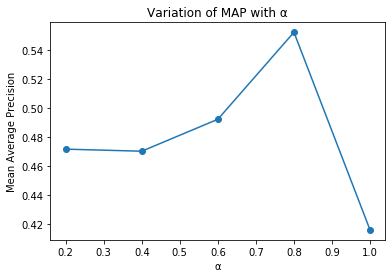

In [55]:
from matplotlib import pyplot as plt
alpha_vals = [0.2, 0.4, 0.6, 0.8, 1.0]
MAP = [0.47159366286333215, 0.47016466491696446, 0.4921917289476388, 0.5522222222222222, 0.41588287521481964]

plt.plot(alpha_vals, MAP, marker='o')
plt.title('Variation of MAP with α')
plt.xlabel('α')
plt.ylabel('Mean Average Precision')
plt.pause(0.5)
plt.show()